# VQVAE for Image Generation - FashionMNIST Dataset
**Author:** Jeanne Malécot 

This is the report notebook for the Optional Homework n°1 (IA323).  
Most of the functions used are defined in Python scripts, to make the notebook lighter.

## Getting Started

In [1]:
#useful imports
import os
import copy

import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchinfo
import random

import matplotlib.pyplot as plt

from scripts.train import train_model
from scripts.reconstruct import reconstruct, show_recon, plot_latent_space
from models.vqvae import VQVAE

##### Load FashionMNIST dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

#load FashionMNIST
train_set = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)
test_set = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

print(f"len train set: {len(train_set)}\nlen test set: {len(test_set)}")
print(f"image shape: {train_set[0][0][0].shape}")

len train set: 60000
len test set: 10000
image shape: torch.Size([28, 28])


The Fashion MNIST dataset consists of 70,000 images, divided into a training set and a test set.   
Each image measures 28x28, has a single channel (greyscale) and is associated with a label (from a list of 10).

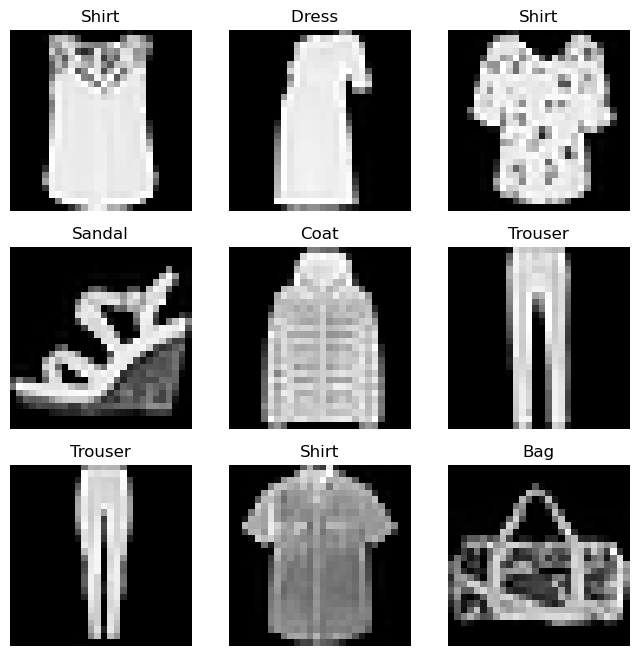

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress  ",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

#visualisation
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().numpy(), cmap="gray") 
plt.show()

Due to the dimensions, the image are not really precise, so we will focus on the generation of a identifiable shape, and not the obtention of identical textures in reconstruction for example.

## Training VQVAE for reconstruction

In [4]:
#device
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device:', device)

device: cuda


The model's arguments are provided by a config dict so that the fine tuning will be easier from this notebook.  

In addition to the 'usual' parameters of a model training, we will deal with:

- `gamma`: balances the VQ loss and the reconstruction loss*, in the final loss (used for back-porpagation)
  
And parameters specifics to the VQ VAE architecture:
  
- `latent_dim`: the embedding dimension
- `n_embeddings`: the number of embeddings
- `beta`: the commitement cost (for the commitement loss of the VQ)


_* about the reconstruction los, I used the MSE loss, that seems the more pertienent to get accurate reconstruction. Maybe it could have been usefull to add a loss that would learn more 'global' informations about the shape, for example (I am thinking of a KLD loss, for example)._

In [5]:
#config
config = {
    'n_epochs': 15, 
    'lr': 0.001, 
    'gamma': 0.7,
    'model': {
        'batch_size': 200, 
        'n_channels': 1, 
        'channels': [128, 256, 512],
        'latent_dim': 64,
        'n_embedding': 512,
        'beta': 0.5,
        }
    } 

The VQ-VAE has encoder-decoder architecture, and I went for 4 downsampling (and upsampling) steps, that required to augment the size of the images (they have to be divisible by 2^4, to avoid shapes mismatching with up-convolutions)

In [6]:
vqvae = vqvae = VQVAE(config['model']).to(device)
torchinfo.summary(vqvae, (1, 1, 28,28), device = str(device))


Layer (type:depth-idx)                        Output Shape              Param #
VQVAE                                         [1, 1, 28, 28]            --
├─EncoderBlock: 1-1                           [1, 64, 7, 7]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─Sequential: 3-1                   [1, 128, 28, 28]          1,280
│    │    └─Sequential: 3-2                   [1, 256, 14, 14]          295,168
│    │    └─Sequential: 3-3                   [1, 512, 7, 7]            1,180,160
│    │    └─Sequential: 3-4                   [1, 64, 7, 7]             32,832
├─VectorQuantizer: 1-2                        [1, 64, 7, 7]             32,768
├─DecoderBlock: 1-3                           [1, 1, 56, 56]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─Sequential: 3-5                   [1, 512, 7, 7]            33,280
│    │    └─Sequential: 3-6                   [1, 256, 14, 14]      

#### Fine tuning of the VQ-VAE

The training loop is also defined in an additional script, that I ran for many different configurations.  
I also implemented a grid-search executable script, to help me fine-tuning the parameters.

In [7]:
model_dict, loss_dict = train_model("vqvae", train_set, config, device)
print(f"Loss: {model_dict['train_loss']:.4f}")

Output()

Loss: 0.1217


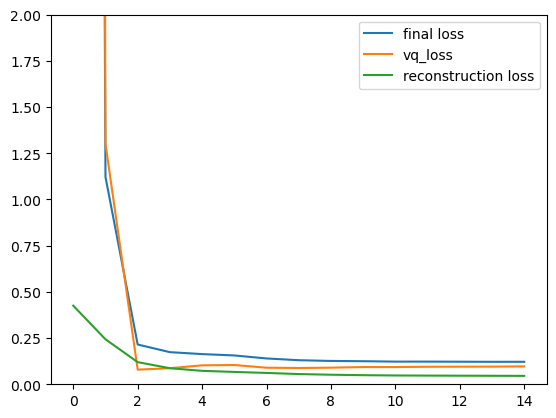

In [8]:
loss = loss_dict['loss']
vq_loss = loss_dict['vq_loss']
reconstruction_loss = loss_dict['reconstruction_loss']

x = np.arange(len(loss))

plt.figure()

plt.plot(x, loss, label='final loss')
plt.plot(x, vq_loss, label='vq_loss')
plt.plot(x, reconstruction_loss, label='reconstruction loss')

plt.legend()
plt.ylim(ymin=0, ymax=2)

plt.show()

Reconstructing images:   0%|          | 0/10000 [00:00<?, ?it/s]

latent_vectors (10000, 49)
reduced_indices (10000, 2)


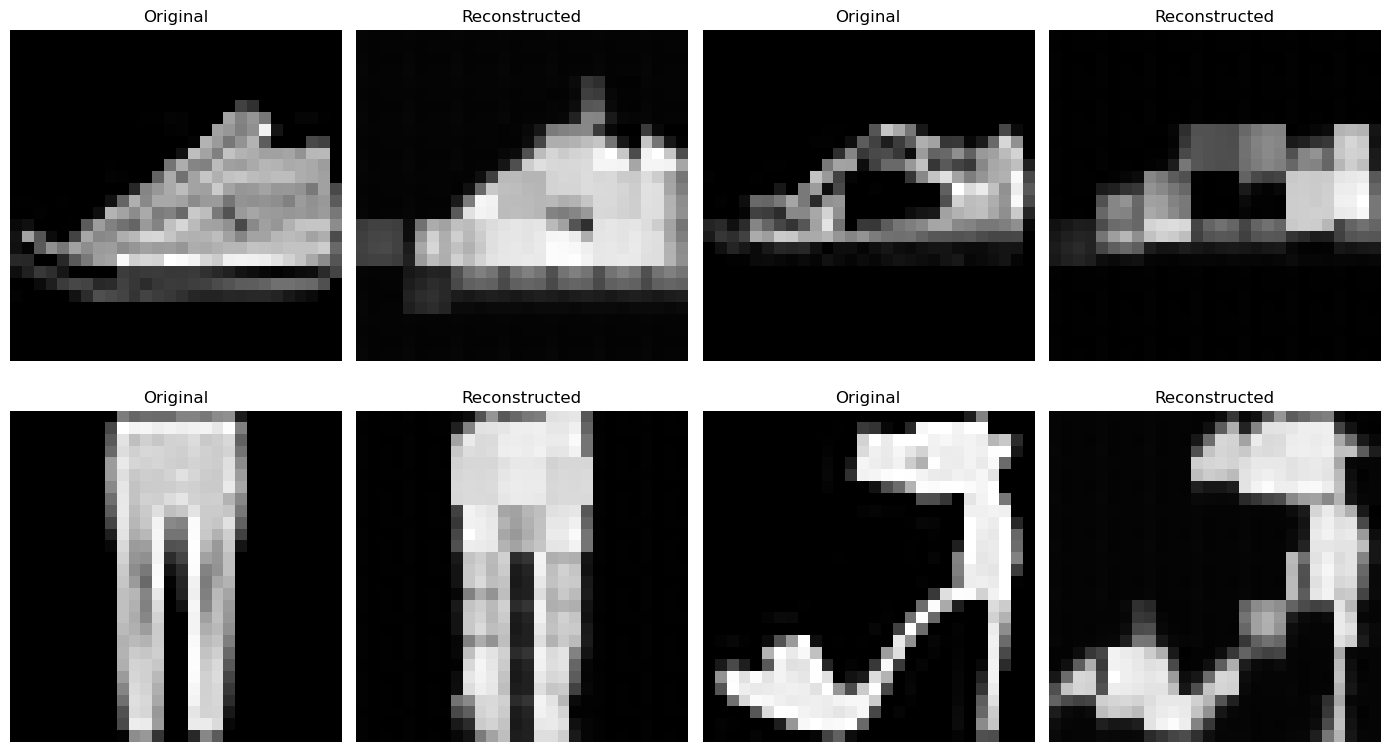

In [14]:
model = model_dict['model']

image_dicts, label_dist, reduced_indices, latent_labels = reconstruct(model, test_set, device)
show_recon(image_dicts)

The latent indices (representation in the embedding space) of an image are saved during the forward pass, so while reconstructing the test_set, we are able to learn a distribution of the different embeddings for **each label**, that should make us able to generate an image of one particular label, by sampling the vectors to decode according to this distribution.  

We can use a PCA with 2 components on the latent indices of each reconstructed images to visualize the embedding space in 2 dimensions.

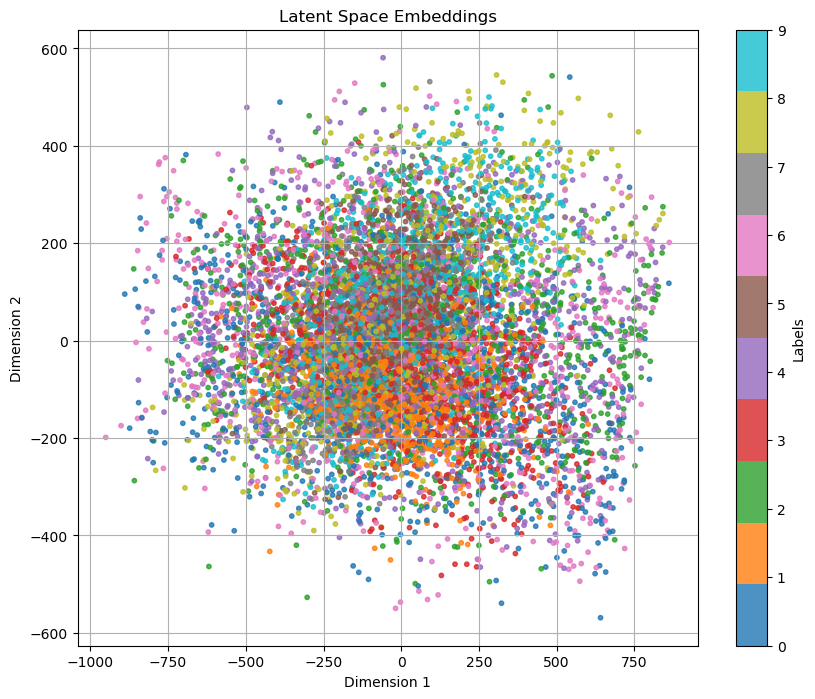

In [15]:
plot_latent_space(reduced_indices, latent_labels)

It is hard to distinguish the 10 different labels on the plot, which means that the model has pain to learn really specific representations for each labels.  
However, the way that some labels are a bit closer to others makes sense: It seems normal that the representation of a sneaker will be closer to the representation of a sandal for example: the global shape is quiet the same.

To sample new vectors, we have to convert the the vectors obtained into probability distributions.

In [16]:
def to_prob(vector):
    label_distribution = vector /( vector.sum() + 1e-3 )
    return label_distribution

I could have used a Softmax to obtain a probability distribution, but the presence of both zero and really high values required to add a temperature, that I had a hard-time to determine (and was seemed to be dependant on the label chosen) 

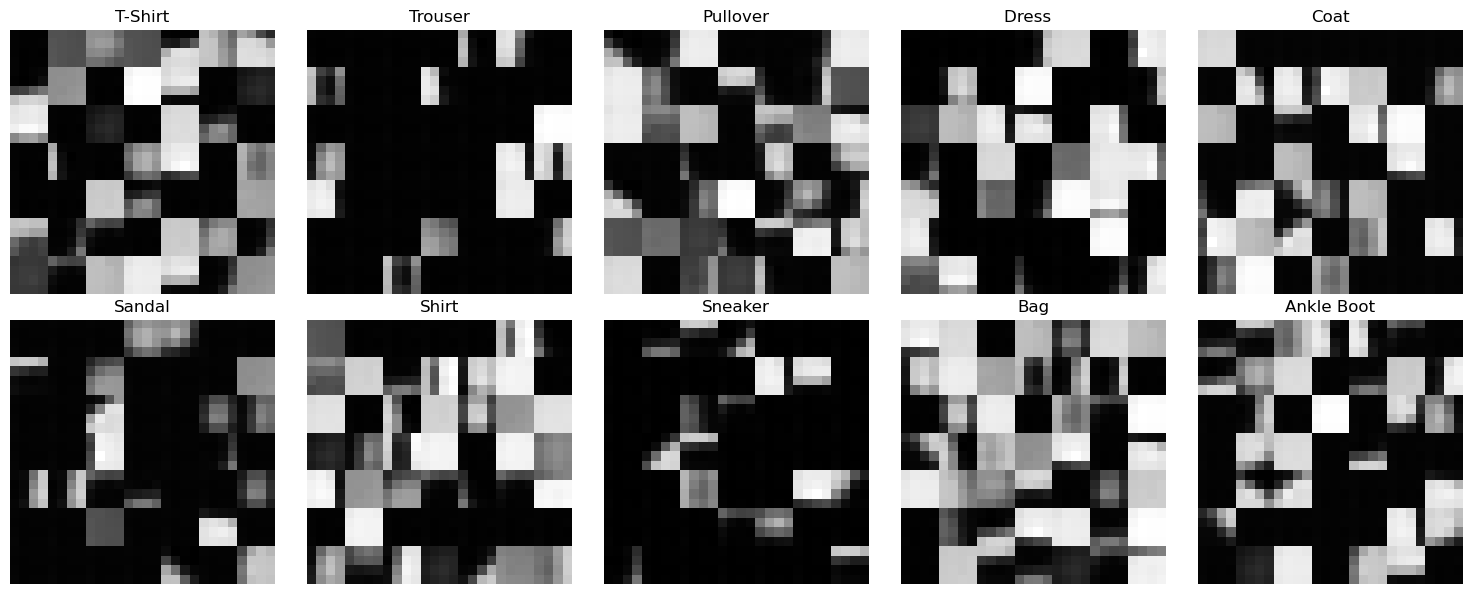

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for label in range(10):
    dist = label_dist[label] 
    label_prob = to_prob(dist)  
    generated_image = model.generate(label_prob, (28, 28))  

    row = label // 5
    col = label % 5

    axes[row, col].imshow(generated_image.detach().cpu().numpy(), cmap='gray')
    axes[row, col].set_title(f"{labels_map[label]}")
    axes[row, col].axis('off')  
    
plt.tight_layout()
plt.show()

The generations of new images from those distributions are not really convincing... 
We can see different patterns for each label, but none of them looks like an image. The way I sample the vectors is probably in cause, but I was not able to fix it in the time I had despite a few attempts.

The training time and access to resources were also an issue: I would perhaps have had better results by just increasing the depth of the model or training it on more epochs, but I am not that sure that it was the only issue...